# Groundwater head data processing

This script reads the groundwater head measurements in absolute pressure [cmH20] and makes a barometric compensation by subtracting the barometric pressure.

Steps in this script:
1. Reads two xlsx-files, one with absolute pressure and the other with barometric pressure. The script expects three columns in each: date and time, values, and quality control for each value with either a Y for accepted values or an N for discarded values. The barometric compensation is then made.
2. Transforms the values to masl.
3. Resamples the data to daily values and visualises the results.
4. Exports the data

This can then be done for each of the groundwater head time series. If the points are close to each other, the same time series for barometric pressure can be used. 

Joaquim Altimiras Granel, 2024

In [37]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Obtain and merge data

# Mismatches in timesteps is handled by the merge_asof function below

def obtain_data():
    
    # Prompt user for file paths
    p_baro_file = input("Enter the path of the barometric pressure file (P_baro): ")
    p_absolute_file = input("Enter the path of the absolute pressure file (P_absolute): ")
    
    # Read the data from the Excel files
    # Read the files, use columns 1, 2 and 3 and assign column names
    p_baro_data = pd.read_excel(p_baro_file, usecols=[0, 1, 2], names=['Date/time', 'P_baro', 'Quality accepted?'])
    p_absolute_data = pd.read_excel(p_absolute_file, usecols=[0, 1, 2], names=['Date/time', 'P_absolute', 'Quality accepted?'])

    # Quality control
    # Filter out rows where 'Quality accepted?' is 'N'
    # Checks each row if the value is Y. If it is, it saves it, otherwise not
    p_baro_data = p_baro_data[p_baro_data['Quality accepted?'] == 'Y']
    p_absolute_data = p_absolute_data[p_absolute_data['Quality accepted?'] == 'Y']
    
    # Ensure the DateTime columns are in correct format
    # Converts the first column to datetime according to pandas
    p_baro_data['Date/time'] = pd.to_datetime(p_baro_data['Date/time'])
    p_absolute_data['Date/time'] = pd.to_datetime(p_absolute_data['Date/time'])

    # Merge the datasets on the DateTime column with a tolerance, takes closest value if perfect match cannot be found
    # The tolerance is very important, since some values might be removed in the filter process
    # If the merge_asof does not find anything within the tolerance, it leaves NaN in that space, which can be seen later
    merged_data = pd.merge_asof(p_baro_data.sort_values('Date/time'), 
                                p_absolute_data.sort_values('Date/time'), 
                                on='Date/time', 
                                tolerance=pd.Timedelta('2 hours'),
                                direction='nearest')

    return merged_data

merged_data = obtain_data()

# Calculate compensated pressure and add it to the DataFrame
merged_data['P_compensated'] = merged_data['P_absolute'] - merged_data['P_baro']

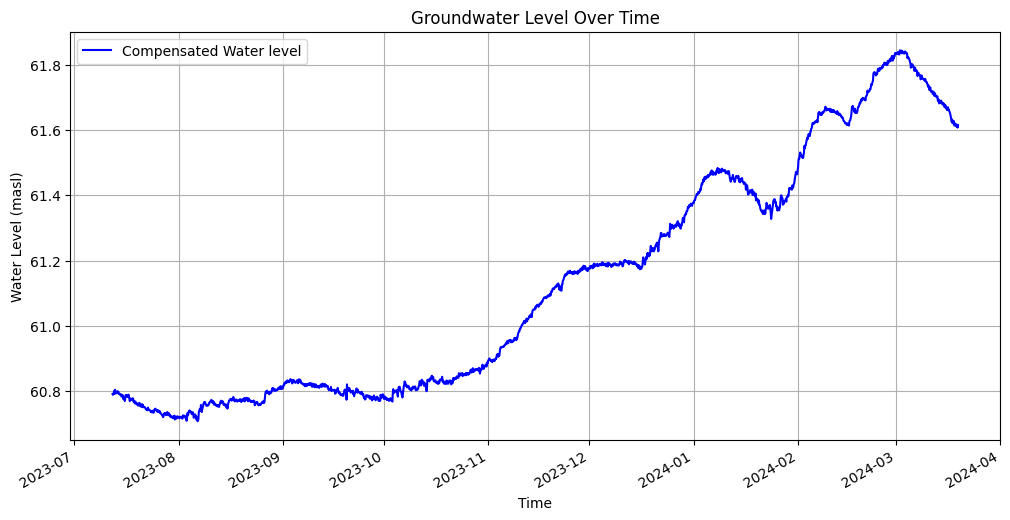

In [38]:
# Transform data to masl.

# Reference level in meters above sea level at top of the well
reference_level = float(input("Enter the reference level in meters above sea level: "))

# Distance from top of well to submerged transducer
diver_distance = float(input("Enter the distance from top of well to submerged transducer in meters: "))

# Calculate diver level
diver_level = reference_level - diver_distance

# Recalculate compensated series to masl.
merged_data['h_compensated'] = merged_data['P_compensated'] / 100 + diver_level


# Visualize the results

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Compensated Water Pressure
plt.plot(merged_data['Date/time'], merged_data['h_compensated'], label='Compensated Water level', color='blue', linestyle='-')

# Add titles and labels
plt.title('Groundwater Level Over Time')
plt.xlabel('Time')
plt.ylabel('Water Level (masl)')
plt.legend()

# Improve formatting of the x-axis dates
plt.gcf().autofmt_xdate()  # Auto-format the date labels for better readability
plt.grid(True)  # Add a grid for better readability

# Display the plot
plt.show()

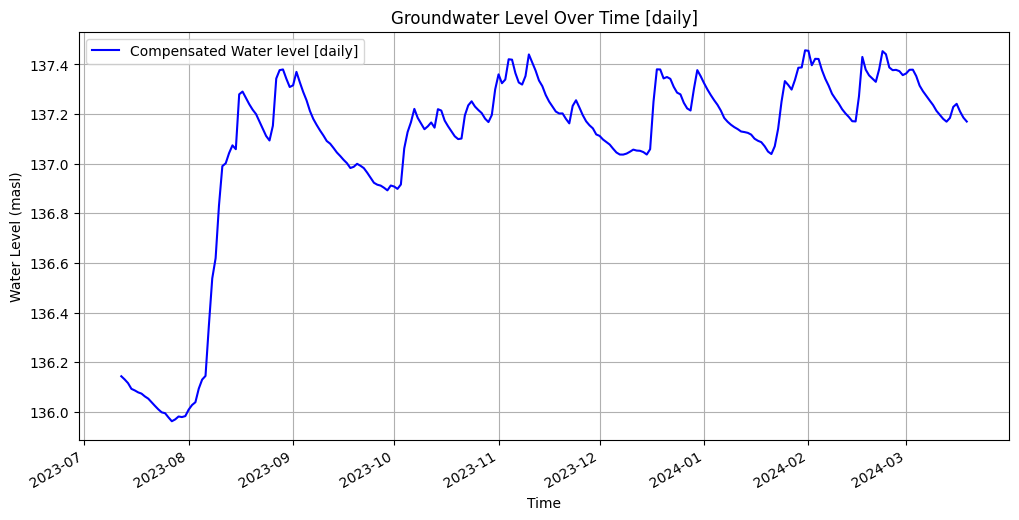

In [36]:
# Resample for daily averages

# Create new dataframe with columns 0 and 6
daily_avg = merged_data.iloc[:, [0, 6]].copy()

# Set the date column as index
daily_avg.set_index(daily_avg.columns[0], inplace=True)

# Resample for daily average
daily_avg = daily_avg.resample('D').mean()

# Remove index setting
daily_avg = daily_avg.reset_index()

# Visualize resampeled data
# Create the plot
plt.figure(figsize=(12, 6))

# Plot Compensated Water Pressure
plt.plot(daily_avg['Date/time'], daily_avg['h_compensated'], label='Compensated Water level [daily]', color='blue', linestyle='-')

# Add titles and labels
plt.title('Groundwater Level Over Time [daily]')
plt.xlabel('Time')
plt.ylabel('Water Level (masl)')
plt.legend()

# Improve formatting of the x-axis dates
plt.gcf().autofmt_xdate()  # Auto-format the date labels for better readability
plt.grid(True)  # Add a grid for better readability

# Display the plot
plt.show()

In [31]:
# Export data function

def export_result(dataframe):
    # Input name of original file
    original_water_file = input("Enter the name of the original water pressure file (P_absolute): ")

    # Let the user specify the output directory
    #compensated_dir = input("Enter the directory where you want to save the file: ")
    #if not os.path.exists(compensated_dir):
    #    os.makedirs(compensated_dir, exist_ok=True)

    # Specify the directory to save the file
    compensated_dir = r'2_data_processing\2.4_groundwater_head_data\processed_data'
    if not os.path.exists(compensated_dir):
        os.makedirs(compensated_dir, exist_ok=True)

    # Generate the file path for the new Excel file
    base_file_name = os.path.basename(original_water_file)
    new_file_name = base_file_name + '_compensated_daily' + '.xlsx'
    file_path = os.path.join(compensated_dir, new_file_name)

    # Export DataFrame to Excel
    try:
        dataframe.to_excel(file_path, index=False)
        print(f"Data successfully exported to {file_path}")
    except Exception as e:
        print(f"Error exporting data: {e}")

#export_result(merged_data)
export_result(daily_avg)
#export_result(weekly_avg)

Data successfully exported to C:\Users\JMAG\OneDrive - Chalmers\Arbetsfiler Joaquim\Working material\4_outputs\gw_level_data\compensated_data\EG534_long_compensated_daily.xlsx
